# Timeseries of 2D and 3D variables

This file generates plots of 2 and 3D model output from the simulations for either a single run (more variables plotted) or multiple runs (specific variables plotted).


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
import warnings
from scipy.interpolate import griddata
import util


warnings.filterwarnings('ignore')
run_dir = "/glade/work/sturbeville/DPSCREAM_simulations/all_run_files/"
run_scr = "/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/"

# --- begin user input ---
comp_name = "other"
runs, run_names, colors = util.get_comp_names(comp_name)
print(run_names)

# comp_name = "oldvnew"
# run="dpscream_rce_small_3km_aa_default"
# old="scream_dp_RCE_SMALL_3km_f_default"
# runs = [run, old]
# run_names=["new def", "old def"]
# colors=["b","C0"]

onerun = False
# one run plots:
plot2d_all = True
plot3d_all = True
plot3d_cld = True
plotw = False
animate = True
# multi-run plots:
plot2d_rad = True
plot2d_var = None  # default: None; options: TMQ, TGCLDIWP, any 2D variable
plot_jhist=False
# --- end user input ---

# which runs to plot together
# runs, run_names, colors = util.get_comp_names(comp_name)
# which plots to plot
if not onerun:
    plot2d_all=False
    plot3d_all=False
    plot3d_cld=False
    plotw=False
    animate=False

['Default', 'New ice nuc', 'LS ascent']


# Plot time series for 2D variables

We plot the time series of each variable in the file. We just plot relevant variables by getting var names from a list saved in this directory ([h1_varnames](h1_varnames)).

## plot 2d timeseries for one run

Variables directly output by the model (2D fields averaged over space, plotted as a timeseries)

In [3]:
if onerun and plot2d_all:
    varnames = open("h1_varnames","r").read().split("\n")
    print("variable length", len(varnames))
    ds = xr.open_dataset(run_scr+"{}/run/{}.eam.h1.2000-01-01-00000.nc".format(run, run))
    # ds = xr.open_dataset(run_scr+"{}/run/{}.eam.h1.2000-01-01-00000.nc".format(run,run))
    # plot
    r,c = 9,5
    fig, ax = plt.subplots(r, c, figsize=(c*4, r*3), sharex=True)
    n = 0
    for i in range(r):
        for j in range(c):
            var = varnames[n]
            data_weighted_avg = ds[var].weighted(ds.area).mean(dim=["ncol"])
            ax[i,j].plot(data_weighted_avg[:-1])
            ax[i,j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
            n+=1
    plt.savefig("plots/timeseries_h1_mean_run_{}.png".format(run),dpi=140)
    plt.show()

## Secondary radiative variables for several runs

- Net downward radiative flux at top of atmosphere: RTOA = FSNTOA-FLUT
- Clearsky version: RTOACLR = FSNTOAC-FLUTC
- Net downward radiative flux at top of the model: RTOM = FSNT-FLNT 
- Net downwards radiative flux at surface: RSFC = FSNS-FLNS
- Clearsky version: RSFCCLR = FSNSC-FLNSC
- Energy input into Ocean = QOCN = RSFC-LHFLX-SHFLX
- Net heating of atmosphere (in W/m2): QATM = RTOM-QOCN
- Precipitation (in W/m2) --- convert from m/s (multiply by latent heat of condensation, Lcond, and density of liquid water, I think)
- Atmospheric cloud radiative effect: ACRE = RTOA-RTOACLR - (RSFC-RSFCCLR) 


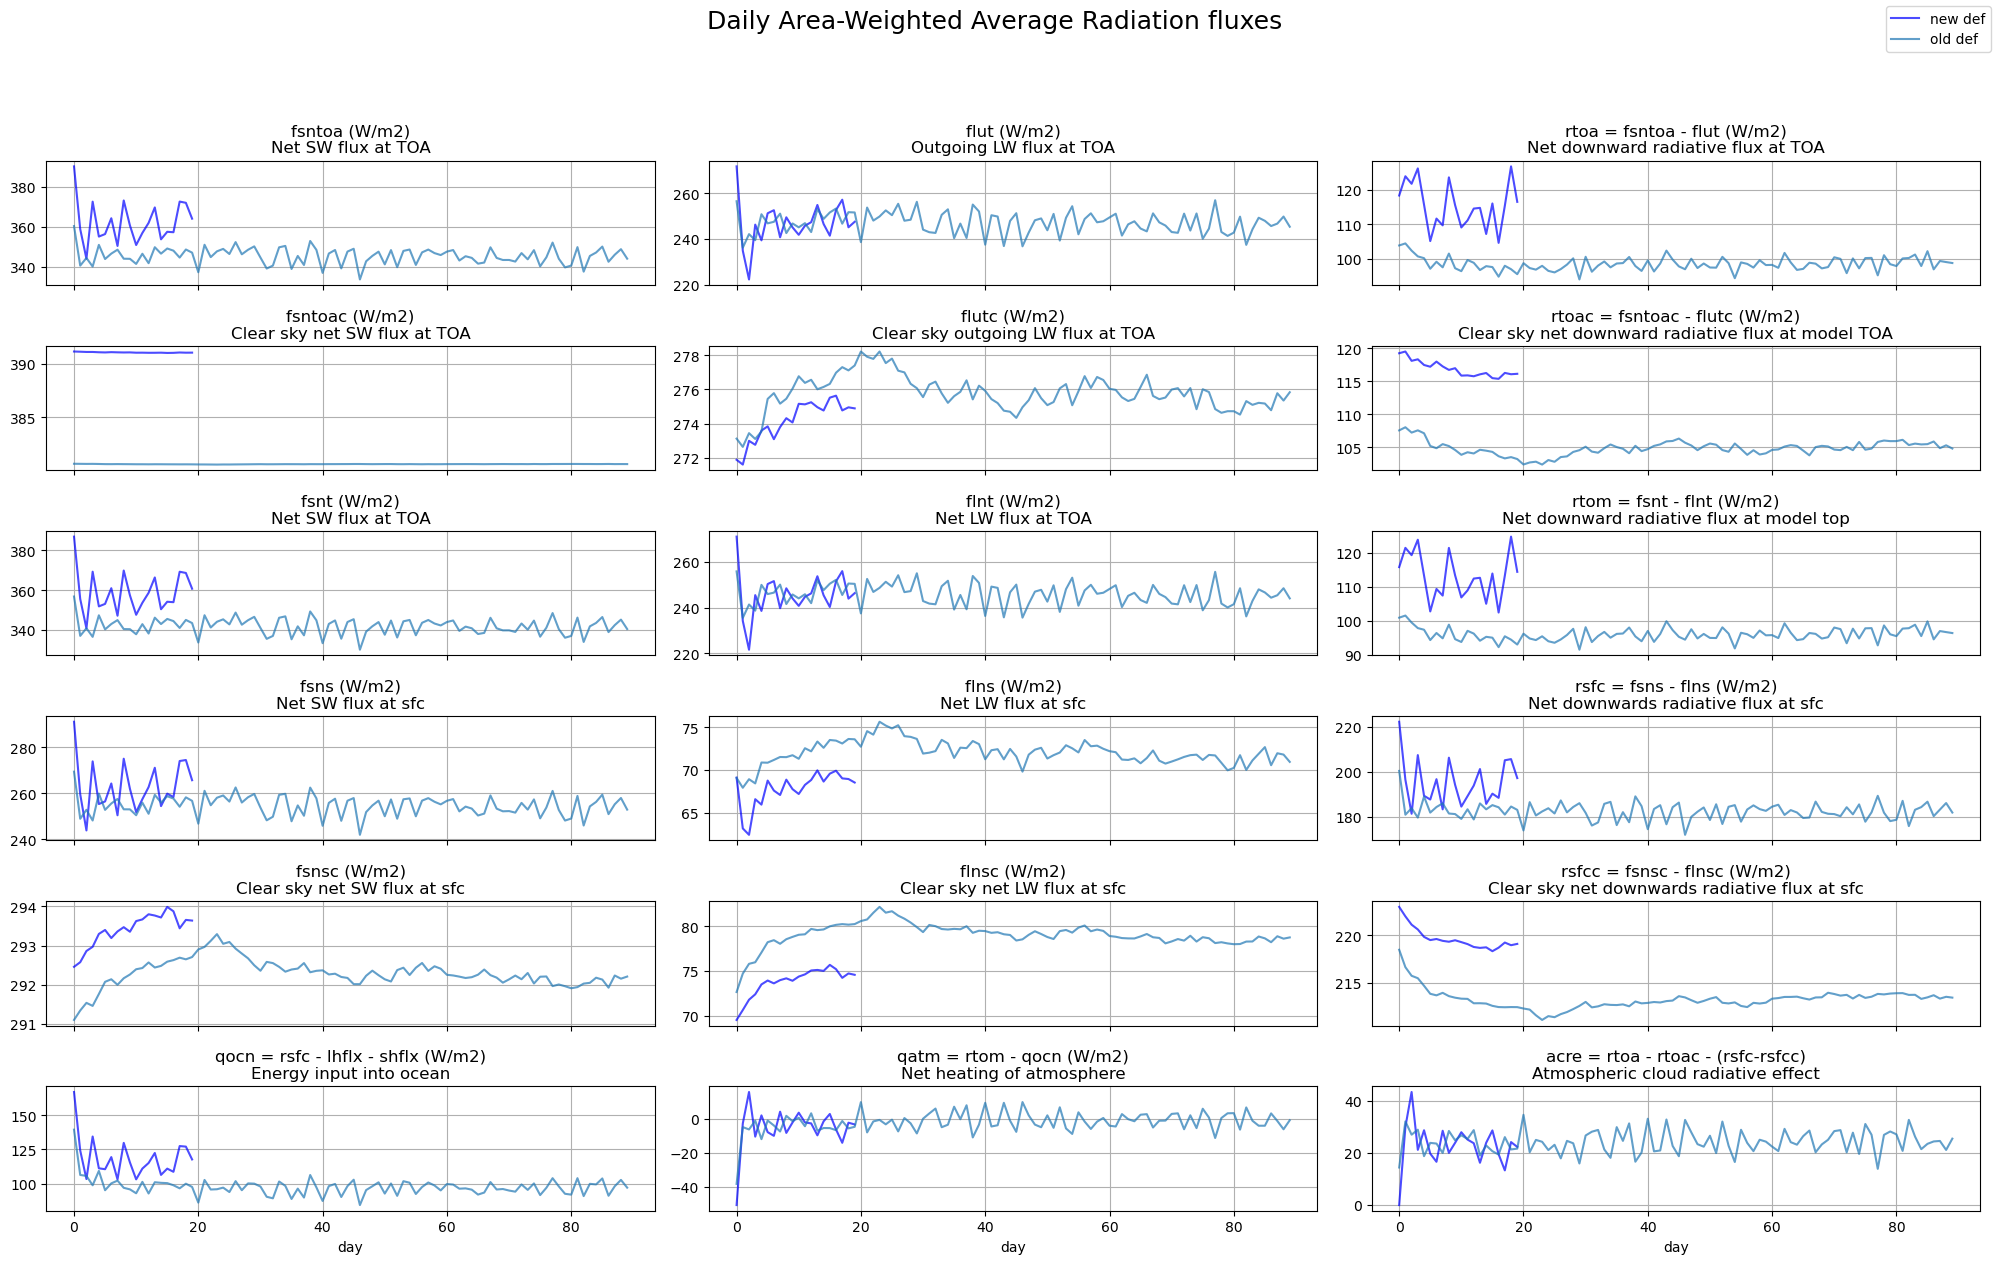

In [4]:
if plot2d_rad:
    print("plotting...")
    fig, ax = plt.subplots(6,3, figsize=(20,12), sharex=True)
    for j in range(len(runs)):
        if runs[j][:2]=="dp":
            ds = xr.open_dataset(run_scr+runs[j]+"/run/"+runs[j]+
                             ".eam.h1.2000-01-01-00000.nc")
        else:
            ds = xr.open_dataset(run_dir+runs[j]+
                             ".eam.h1.2000-01-01-00000.nc")
        # secondary variables (radiation related)
        rtoa = ds["FSNTOA"]-ds["FLUT"]
        rtoac = ds["FSNTOAC"]-ds["FLUTC"]
        rtom = ds["FSNT"]-ds["FLNT"]
        rsfc = ds["FSNS"]-ds["FLNS"]
        rsfcc = ds["FSNSC"]-ds["FLNSC"]
        qocn = rsfc-ds["LHFLX"]-ds["SHFLX"]
        qatm = rtom-qocn
        acre = rtoa-rtoac-(rsfc-rsfcc)
        # daily weighted averages (and average over space)
        fsntoa_da = ds["FSNTOA"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        flut_da = ds["FLUT"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        rtoa_da = rtoa.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

        fsntoac_da = ds["FSNTOAC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        flutc_da = ds["FLUTC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        rtoac_da = rtoac.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

        fsnt_da = ds["FSNT"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        flnt_da = ds["FLNT"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        rtom_da = rtom.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

        fsns_da = ds["FSNS"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        flns_da = ds["FLNS"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        rsfc_da = rsfc.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

        fsnsc_da = ds["FSNSC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        flnsc_da = ds["FLNSC"].resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        rsfcc_da = rsfcc.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

        qocn_da = qocn.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        qatm_da = qatm.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])
        acre_da = acre.resample(time="1D").mean().weighted(ds.area).mean(dim=["ncol"])

        day = range(len(fsntoa_da.time)-1)
        # plot daily averages

        a=0.7
        i=0  # FSNTOA, FLUT, RTOA
        if j>2:
            ls = 'dashed'
        else:
            ls = 'solid'
        ax[i,0].plot(day, fsntoa_da[:-1], color=colors[j], label=run_names[j], alpha=a, linestyle=ls)
        ax[i,1].plot(day, flut_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,2].plot(day, rtoa_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        # title
        ax[i,0].set_title("fsntoa (W/m2)\nNet SW flux at TOA")
        ax[i,1].set_title("flut (W/m2)\nOutgoing LW flux at TOA")
        ax[i,2].set_title("rtoa = fsntoa - flut (W/m2)\nNet downward radiative flux at TOA")

        i=1  # FSNTOAC, FLUTC, RTOAC
        ax[i,0].plot(day, fsntoac_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,1].plot(day, flutc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,2].plot(day, rtoac_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        # title
        ax[i,0].set_title("fsntoac (W/m2)\nClear sky net SW flux at TOA")
        ax[i,1].set_title("flutc (W/m2)\nClear sky outgoing LW flux at TOA")
        ax[i,2].set_title("rtoac = fsntoac - flutc (W/m2)\nClear sky net downward radiative flux at model TOA")

        i=2  # FSNT, FLNT, RTOM
        ax[i,0].plot(day, fsnt_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,1].plot(day, flnt_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,2].plot(day, rtom_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        # title
        ax[i,0].set_title("fsnt (W/m2)\nNet SW flux at TOA")
        ax[i,1].set_title("flnt (W/m2)\nNet LW flux at TOA")
        ax[i,2].set_title("rtom = fsnt - flnt (W/m2)\nNet downward radiative flux at model top")

        i=3  # FSNS, FLNS, RSFC
        ax[i,0].plot(day, fsns_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,1].plot(day, flns_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,2].plot(day, rsfc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        # title
        ax[i,0].set_title("fsns (W/m2)\nNet SW flux at sfc")
        ax[i,1].set_title("flns (W/m2)\nNet LW flux at sfc")
        ax[i,2].set_title("rsfc = fsns - flns (W/m2)\nNet downwards radiative flux at sfc")

        i=4  # FSNSC, FLNSC, RSFCC
        ax[i,0].plot(day, fsnsc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,1].plot(day, flnsc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,2].plot(day, rsfcc_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        # title
        ax[i,0].set_title("fsnsc (W/m2)\nClear sky net SW flux at sfc")
        ax[i,1].set_title("flnsc (W/m2)\nClear sky net LW flux at sfc")
        ax[i,2].set_title("rsfcc = fsnsc - flnsc (W/m2)\nClear sky net downwards radiative flux at sfc")

        i=5  # QOCN, QATM, ACRE
        ax[i,0].plot(day, qocn_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,1].plot(day, qatm_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        ax[i,2].plot(day, acre_da[:-1], color=colors[j], alpha=a, linestyle=ls)
        # title
        ax[i,0].set_title("qocn = rsfc - lhflx - shflx (W/m2)\nEnergy input into ocean")
        ax[i,1].set_title("qatm = rtom - qocn (W/m2)\nNet heating of atmosphere")
        ax[i,2].set_title("acre = rtoa - rtoac - (rsfc-rsfcc)\nAtmospheric cloud radiative effect")

    for k in range(6):
        for m in range(3):
            ax[k,m].grid(True)
            ax[-1,m].set_xlabel("day")
    fig.suptitle("Daily Area-Weighted Average Radiation fluxes", y=1.05, fontsize=18)
    fig.legend()
    plt.tight_layout()
    plt.savefig("plots/timeseries_dailyavg_radiation_{}.png".format(comp_name), dpi=140, pad_inches=0.3)
    plt.show()

## plot timeseries of a 2D variable of your choice

In [27]:
plot2d_var=None
if plot2d_var is not None:
    print(plot2d_var)
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    for i in range(len(runs)):
        ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}.eam.h1.2000-01-01-00000.nc".format(runs[i]))
        ds_area = ds.area
        ds = ds[plot2d_var]
        dtperday = np.argmin(abs(ds.time.dt.day - ds.time.dt.day[0].values - 1).values)
        print(i, "dt per day:", dtperday, "means", 24//dtperday, "hourly output")
        ntime = np.linspace(0,ds.shape[0]/dtperday, ds.shape[0])
        ax.plot(ntime[:-1], ds.weighted(ds_area).mean(dim=["ncol"])[:-1], 
                color=colors[i], alpha=0.6, label=run_names[i])
    ax.set(ylabel=plot2d_var, xlabel="days")
    ax.legend()
    ax.grid(True)
    plt.savefig("plots/single_var/timeseries_{}_2D_{}.png".format(plot2d_var, comp_name), dpi=120)
    plt.show()

# Plot timeseries for 3D variables

Plot all variables 3Dlev as pcolormesh

<xarray.DataArray 'IWC' (time: 81, lev: 128, ncol: 1296)>
dask.array<open_dataset-IWC, shape=(81, 128, 1296), dtype=float32, chunksize=(81, 128, 500), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-21 00:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         1
    units:         kg/m3
    long_name:     Grid box average ice water content
    cell_methods:  time: point
50


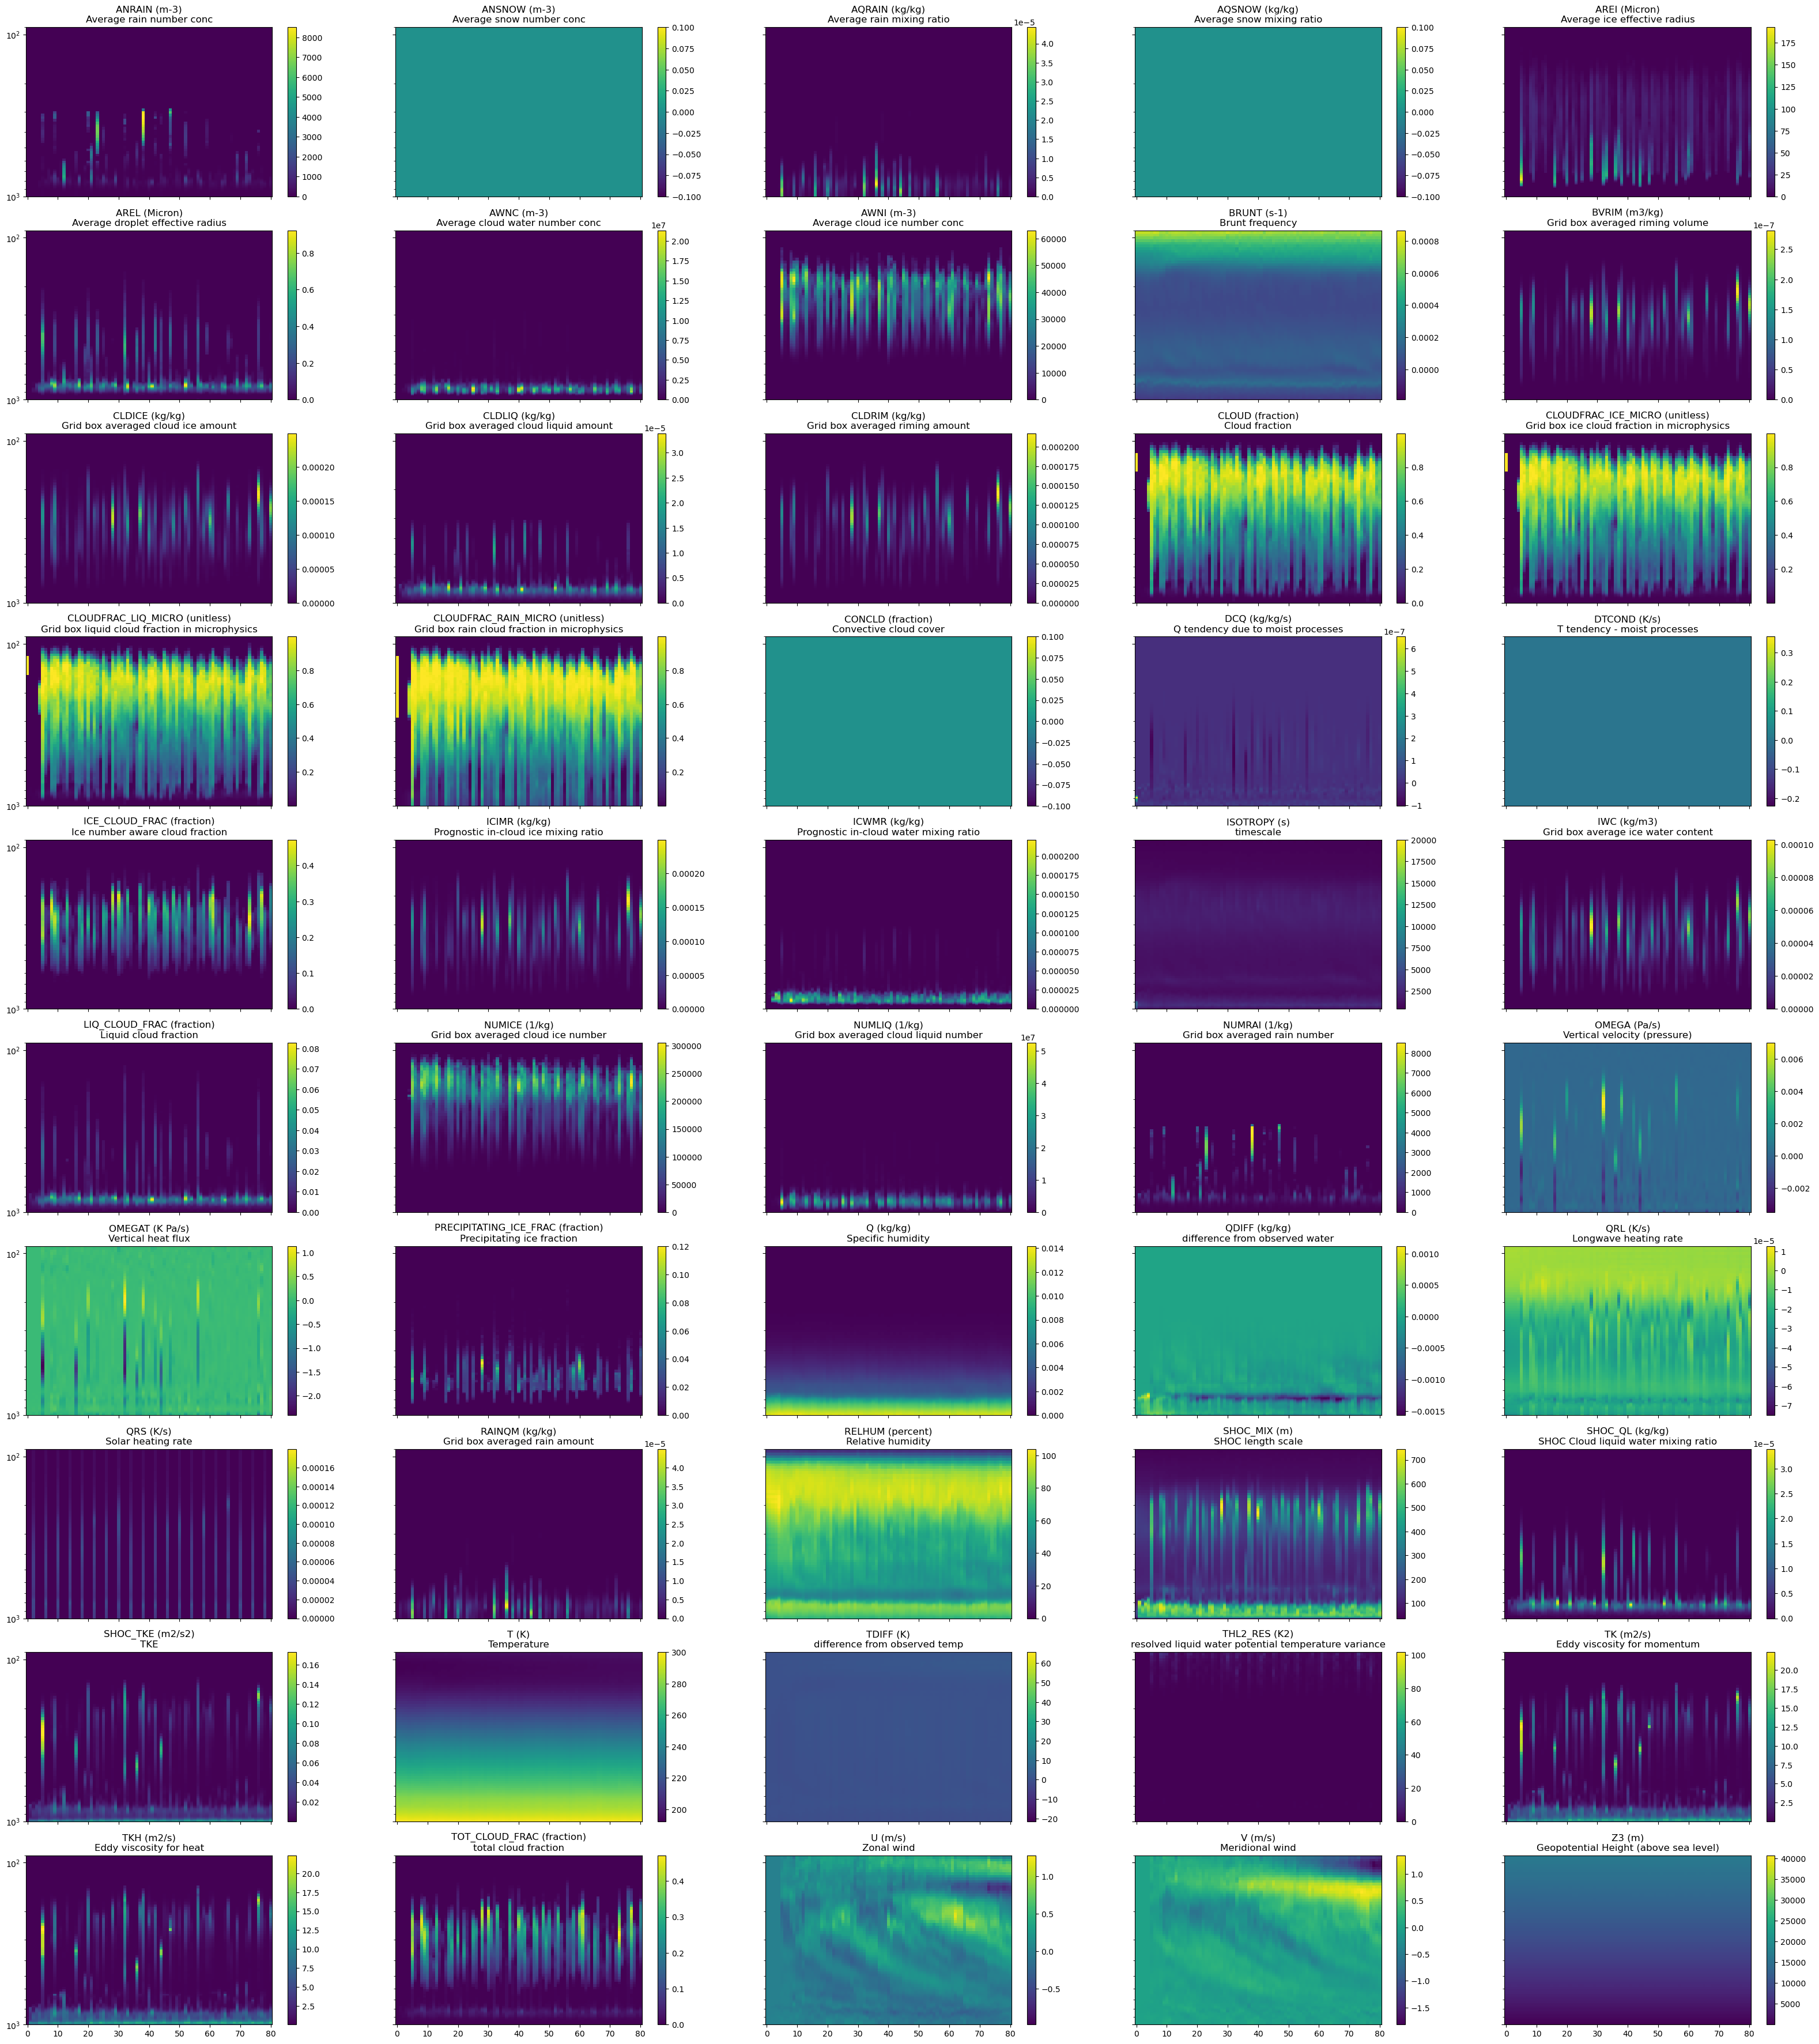

In [16]:
if onerun and plot3d_all:
    ds = xr.open_dataset(run_dir+"{}/run/{}.eam.h0.2000-01-01-00000.nc".format(run, run), 
                         chunks={"time":120, "ncol":500})
    print(ds.IWC)

    # Choose one of 'h0_varnames_2D', 'h0_varnames_3Dlev', 'h0_varnames_3Dilev'
    file="h0_varnames_3Dlev"
    varnames = open(file,"r").read().split("\n")
    print(len(varnames))

    if file=="h0_varnames_2D":
        a,b = 9,7
        fig, ax = plt.subplots(a,b, figsize=(40,45), sharex=True, sharey=True)
        n = 0
        for i in range(a):
            for j in range(b):
                if n<len(varnames):
                    var = varnames[n]
                    ax[i, j].plot(ds[var].weighted(ds.area).mean(dim=["ncol"]))
                    ax[i, j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
                    n+=1
                else:
                    ax[i, j].axis("off")
        plt.savefig("plots/timeseries_h0_2D_{}.png".format(run),dpi=140)
        plt.show()
    elif file=="h0_varnames_3Dlev":
        a,b = 10,5,
        fig, ax = plt.subplots(a, b, figsize=(40,45), sharex=True, sharey=True)
        n = 0
        for i in range(a):
            for j in range(b):
                if n<len(varnames):
                    var = varnames[n]
                    pc = ax[i,j].pcolormesh(range(len(ds.time)), ds.lev.values, ds[var].weighted(ds.area).mean(dim=["ncol"]).T)
                    ax[i,j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
                    ax[i,j].set_yscale("log")
    #                 ax[i,j].yaxis_inverted()
                    ax[i,j].set_ylim(bottom=1000, top=90)
                    plt.colorbar(pc, ax=ax[i,j])
                    n+=1
                else:
                    ax[i,j].axis("off")
        plt.savefig("plots/timeseries_h0_3Dlev_{}.png".format(run),dpi=140)
        plt.show()
    elif file=="h0_varnames_3Dilev":
        a,b = 5,2
        fig, ax = plt.subplots(a,b, figsize=(15,10), sharex=True)
        n = 0
        for i in range(a):
            for j in range(b):
                if n<len(varnames):
                    var = varnames[n]
                    pc = ax[i,j].pcolormesh(range(len(ds.time)), ds.ilev.values, ds[var].weighted(ds.area).mean(dim=["ncol"]).T)
                    ax[i,j].set_title(var+" ("+str(ds[var].units)+")\n"+str(ds[var].long_name))
    #                 ax[i,j].invert_yaxis()
                    plt.colorbar(pc, ax=ax[i,j])
                    n+=1
                else:
                    ax[i,j].axis("off")

        plt.savefig("plots/timeseries_h0_3Dilev_{}.png".format(run),dpi=140)
        plt.show()
    else:
        raise Exception("check file name: {}".format(file))

## plot 3D timeseries of variables related to clouds

Plot ice and liquid properties
```
AREI, CLDICE, AWNI, CLOUDFRAC_ICE_MICRO, NUMICE, IWC
AREL, CLDLIQ, AWNC, CLOUDFRAC_LIQ_MICRO, NUMLIQ, TEMP
ICE_CLOUD_FRAC, LIQ_CLOUD_FRAC, PRECIPITATING_ICE_FRAC, CLOUDFRAC_RAIN_MICRO, TOT_CLOUD_FRAC, OMEGA
CLOUD, CLDRIM, QRL, QRS, NUMRAI, RELHUM
```
ndays = 40

In [9]:
if onerun and plot3d_cld:
    fig, ax = plt.subplots(4,6, figsize=(40,20), sharex=True, sharey=True)
    ndays = 40
    days = range(len(ds.time[-ndays*24:])) # saved hourly
    
    var = np.array(
        [["AREI", "CLDICE", "AWNI", "CLOUDFRAC_ICE_MICRO", "NUMICE", "IWC"],
         ["AREL", "CLDLIQ", "AWNC", "CLOUDFRAC_LIQ_MICRO", "NUMLIQ", "T"],
         ["ICE_CLOUD_FRAC", "LIQ_CLOUD_FRAC", "PRECIPITATING_ICE_FRAC",
            "CLOUDFRAC_RAIN_MICRO", "TOT_CLOUD_FRAC", "OMEGA"],
         ["CLOUD", "CLDRIM", "QRL", "QRS", "NUMRAI", "RELHUM"]
        ]
    )
    
    for i in range(4):
        for j in range(6):
            if var[i,j] is not None:
                pc = ax[i,j].pcolormesh(days, ds.lev, ds[var[i,j]][-ndays:].weighted(ds.area).mean(dim=["ncol"]).T)
                ax[i,j].axis()
                ax[i,j].set_ylim([1000,90])
                ax[i,j].set_title(var[i,j]+" ("+str(ds[var[i,j]].units)+\
                                  ")\n"+str(ds[var[i,j]].long_name), fontsize=14)
                plt.colorbar(pc, ax=ax[i,j])
            else:
                ax[i,j].axis("off")
    ax[0,0].set_yscale("log")
    plt.savefig("plots/timeseries_3D_cloud_properties_logyscale_{}_last{}days.png".format(run,ndays), dpi=150)
    plt.show()

In [ ]:
if onerun and plotw:
    # data = w.sel(lev=500, method="nearest").values.flatten()
    data = ds.OMEGA.min(axis=1)
    print(data.shape)
    data = data.values.flatten()
    hist, bins = np.histogram(data, bins=[-15,-10,-5,-2,-1,-0.1,0.1,])
    bin_mids = (bins[1:]+bins[:-1])/2
    # hist = hist/len(data)

    fig, ax = plt.subplots(1,1)
    ax.plot(bin_mids,hist,'.-')
    ax.set(xticks=bins,xlabel="Vertical velocity (Pa/s)",ylabel="pdf",
          title="max in column")
    ax.grid(True)
    plt.show()

# MSE variance timeseries

Let's start with PR variance

In [2]:
run = runs[-1]
run

'i_lsascent_a'

In [3]:
# if onerun:
ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run,run)).TMQ
ds_anom = ds - ds.mean(axis=1)
ds_anom_var = ds_anom.var(axis=1)

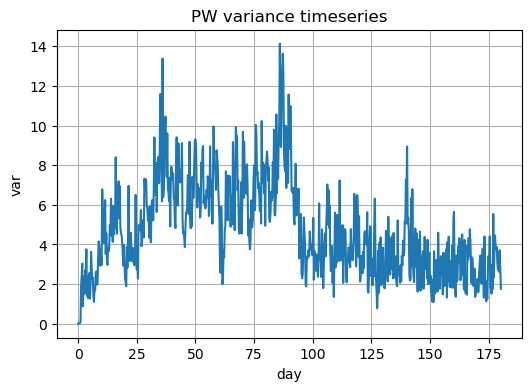

In [4]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(np.arange(0,len(ds_anom_var)/4,0.25), ds_anom_var)
ax.grid()
ax.set(title="PW variance timeseries", ylabel="var", xlabel="day")
plt.savefig("plots/TMQ_var_sst.png", dpi=120)
plt.show()
# Values upto 80 for warmed sst with clear organized convection

# Joint histogram

We want to see if DP-SCREAM also shows the same tendencies for popcorn convection

In [ ]:
if plot_jhist:
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run))
    olr = ds.FLUT
    # prl = ds.PRECL*3600*1000
    # iwp = ds.TGCLDIWP*1000
    # lwp = ds.TGCLDLWP*1000
    swn = ds.FSNT
    swu = ds.FSUTOA
    # ts = ds.TS
    lat = ds.lat
    lon = ds.lon
    x = ds.crm_grid_x
    y = ds.crm_grid_y
    print(olr.shape, swn.shape, swu.shape)

    # Make sure SW vars look reasonable
    # fig, ax = plt.subplots(1,1, figsize=(6,2))
    # ax.plot(range(len(swu.time)), swu.weighted(ds.area).mean(dim=["ncol"]), label="swu")
    # ax.plot(range(len(swu.time)), swn.weighted(ds.area).mean(dim=["ncol"]), label="swn")
    # ax.plot(range(len(swu.time)), (swn+swu).weighted(ds.area).mean(dim=["ncol"]), label="swd")
    # plt.legend()
    # plt.show()

    # calculate albedo
    alb = swu / (swu+swn)

    # plot jhist
    native_grid=False
    if onerun:
        runs= [run]

    for i in range(len(runs)):
        ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_"+runs[i]+\
                             ".eam.h1.2000-01-01-00000.nc")
        olr = ds.FLUT
        swu = ds.FSUTOA
        alb = swu / (swu+ds.FSNT)
        x = ds.crm_grid_x
        y = ds.crm_grid_y
        # plot on native or coarsened to 0.25 deg
        if not(native_grid):
            xi = np.linspace(0, 107170, 100)  # to regrid to ~2km
            yi = np.linspace(0, 107170, 100)  # to regrid to ~2km
            olr_regridded = np.full((len(olr.time), len(xi), len(yi)), np.nan)
            alb_regridded = np.full(olr_regridded.shape, np.nan)
            print("regridding...")
            for t in range(len(olr.time)):
                olr_regridded[t,:,:] = griddata((x[t], y[t]), olr[t], (xi[None,:], yi[:,None]), method='linear')
                alb_regridded[t,:,:] = griddata((x[t], y[t]), alb[t], (xi[None,:], yi[:,None]), method='linear')
            print("\n...done", olr_regridded.shape, alb_regridded.shape)

            olr_regridded = xr.DataArray(olr_regridded, dims=["time","xi","yi"], 
                                         coords={"time":olr.time,"xi":xi,"yi":yi})
            alb_regridded = xr.DataArray(alb_regridded, dims=["time","xi","yi"], 
                                         coords={"time":olr.time,"xi":xi,"yi":yi})
            olr_coarsened = olr_regridded.coarsen(dim={"xi":25,"yi":25}).mean(skipna=True)
            alb_coarsened = alb_regridded.coarsen(dim={"xi":25,"yi":25}).mean(skipna=True)
            print("...coarsened...\n...plotting...")

            util.dennisplot("density",olr_coarsened.values.flatten(),
                            alb_coarsened.values.flatten(),
                            cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2))
            plt.title("RUN {} coarsened to 0.25deg".format(runs[i].upper()),
                      fontsize=20)
            plt.savefig("plots/jhist_0.25deg_{}.png".format(runs[i]), dpi=140)
            plt.show()
        else:
            util.dennisplot("density", 
                            olr.values.flatten(), alb.values.flatten(),
                            cmap="gist_earth_r", 
                            levels=np.arange(-3.4,-1.2,0.2))
            plt.title("RUN {} native output".format(runs[i].upper()),
                      fontsize=20)
            plt.savefig("plots/jhist_native_{}.png".format(runs[i]),
                        dpi=140)
            plt.show()

# Spatial plots animation

In [4]:
onerun = True
animate= True
run = runs[-1]

In [7]:
if onerun & animate:
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run))
    # olr = ds.FLUT
    # prl = ds.PRECL*3600*1000
    # iwp = ds.TGCLDIWP*1000
    # lwp = ds.TGCLDLWP*1000
    iwc = ds.CLDICE*1000
    # pw = ds.TMQ
    x = ds.crm_grid_x
    y = ds.crm_grid_y
    # print(olr.shape, pw.shape)
    print(x.shape, iwc.shape)
    del ds

(722, 1296) (722, 128, 1296)


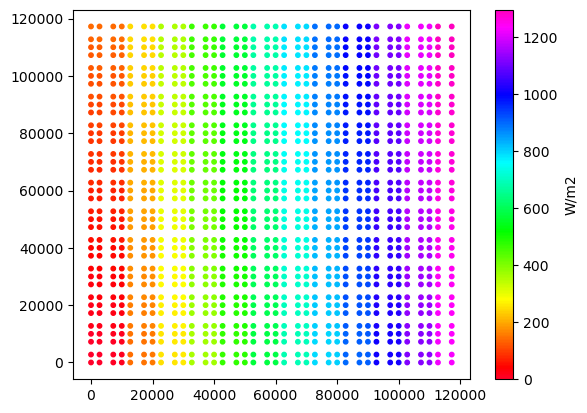

In [7]:
if onerun:
    cmap="gist_rainbow"
    # scatter plot of native grid ncol structure
    t = 45
    im = plt.scatter(x.values[t,:], y.values[t,:], c=olr[t,:].ncol.values,
                     s=10, cmap=cmap)
    plt.colorbar(im, label="W/m2")
    # plt.savefig("plots/grid_points_map.png")
    plt.show()

In [9]:
if onerun & animate:
    # tripcolor plot of native grid OLR
    # t=50
    cmap="YlGnBu"
    cmapr="cividis_r"
    for t in range(20,24): #range(len(olr.time)-2):
        print(t, end=" ")
        fig, ax = plt.subplots(1, 4, figsize=(12,4), sharex=True, sharey=True)
        fig.subplots_adjust(wspace=0)
        # plot
        im_olr = ax[0].tripcolor(x.values[t,:], y.values[t,:], olr[t,:].values,
                                 vmin=80, vmax=310, shading="gouraud", cmap=cmapr)
        fig.colorbar(im_olr, ax=ax[0], orientation="horizontal", label="W/m2", shrink=0.8)
        im_iwp = ax[1].tripcolor(x.values[t,:], y.values[t,:], iwp[t,:].values,
                                 norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4), shading="gouraud",cmap=cmap)
        fig.colorbar(im_iwp, ax=ax[1], label="g/m$^2$", orientation="horizontal", shrink=0.8)
        im_pr = ax[2].tripcolor(x.values[t,:], y.values[t,:], (lwp[t,:].values),
                                shading="gouraud", cmap=cmap, norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4))
        fig.colorbar(im_pr, ax=ax[2], label="g/m$^2$", orientation="horizontal", shrink=0.8)
        im_pr = ax[3].tripcolor(x.values[t,:], y.values[t,:], (pw[t,:].values),
                                shading="gouraud", cmap=cmap, vmin=20, vmax=60)
        fig.colorbar(im_pr, ax=ax[3], label="kg/m2", orientation="horizontal", shrink=0.8)
        # figure settings
        for i in range(4):
            ax[i].set_aspect("equal")
            ax[i].set_xlim([0,107171])
            ax[i].set_ylim([0,107171])
        fig.suptitle((str(olr[t].time.values))+"["+str(t/4)+"]")
        ax[0].set_title("OLR")
        ax[1].set_title("IWP")
        ax[2].set_title("LWP")
        ax[3].set_title("PW (int. WV)")
        ax[3].set_facecolor(cm.get_cmap(cmap,10)(0))
        ax[2].set_facecolor(cm.get_cmap(cmap,10)(0))
        plt.savefig("plots/movie/{}/tripcolor_olr-iwp-pr_{:03d}".format(run, t), bbox_inches="tight", pad_inches=0.5)
        plt.close()

20 21 22 23 

In [16]:
iwc[t]

<xarray.DataArray 'CLDICE' (lev: 128, ncol: 1296)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
    time     object 2000-01-07 06:00:00
Dimensions without coordinates: ncol

plotting...
50 (128, 1296) 1.0 0.21524166


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (324,) and arg 2 with shape (128,).

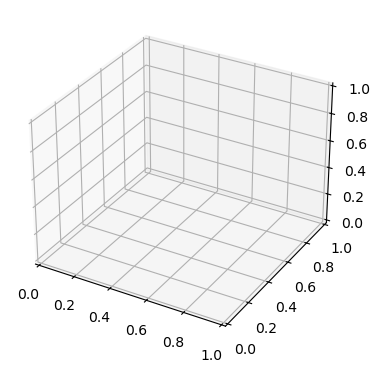

In [23]:
if onerun & animate:
    print("plotting...")
    # tripcolor plot of native grid OLR
    t=50
    cmap="YlGnBu"
    cmapr="cividis_r"
    thres=0.005
    # for t in range(20,22): #range(len(olr.time)-2):
    print(t, end=" ")
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    # iwc_t = iwc[t].where(iwc[t]>thres).values/iwc.isel(time=t).max().values
    iwc_t = np.where(iwc[t] > thres, 1, 0)
    print(np.nanmax(iwc_t), np.nanmean(iwc_t))
    im_olr = ax.scatter(x.values[t,::4], y.values[t,::4], 
                         cmap="Blues", norm=True)
    plt.show()
        

In [1]:
# griddata
# t=200
# cmap="YlGnBu"
# cmapr="cividis_r"
# print(t, end=" ")
# # regrid
# xi = np.linspace(0, 107170, 1000)  # to regrid to ~2km
# yi = np.linspace(0, 107170, 1000)  # to regrid to ~2km
# olr_regridded = griddata((x[t], y[t]), olr[t], (xi[None,:], yi[:,None]), method='linear')
# iwp_regridded = griddata((x[t], y[t]), iwp[t], (xi[None,:], yi[:,None]), method='linear')
# lwp_regridded = griddata((x[t], y[t]), lwp[t], (xi[None,:], yi[:,None]), method='linear')
# pw_regridded = griddata((x[t], y[t]), pw[t], (xi[None,:], yi[:,None]), method='linear')
# X,Y = np.meshgrid(xi,yi)
# # plot
# fig, ax = plt.subplots(1, 4, figsize=(12,4), sharex=True, sharey=True)
# fig.subplots_adjust(wspace=0)
# for i in range(4):
#     ax[i].set_aspect("equal")
# im_olr = ax[0].pcolormesh(X,Y, olr_regridded,
#                           vmin=80, vmax=310, cmap=cmapr)
# fig.colorbar(im_olr, ax=ax[0], orientation="horizontal", label="W/m2", shrink=0.8)
# im_iwp = ax[1].pcolormesh(X,Y, iwp_regridded, cmap=cmap,
#                           norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4))
# fig.colorbar(im_iwp, ax=ax[1], label="g/kg", orientation="horizontal", shrink=0.8)
# im_lwp = ax[2].pcolormesh(X,Y, lwp_regridded, cmap=cmap,
#                           norm=mcolors.LogNorm(vmin=5e-4, vmax=1e4))
# fig.colorbar(im_lwp, ax=ax[2], label="g/kg", orientation="horizontal", shrink=0.8)
# im_pr = ax[3].pcolormesh(X,Y, pw_regridded, cmap=cmap,
#                          # norm=mcolors.LogNorm(vmin=0.1, vmax=40))
#                          vmin=20, vmax=60)
# fig.colorbar(im_pr, ax=ax[3], label="mm/hr", orientation="horizontal", shrink=0.8)
# fig.suptitle(str(olr[t].time.values))
# ax[0].set_title("OLR")
# ax[1].set_title("IWP")
# ax[2].set_title("LWP")
# ax[3].set_title("PW")
# # ax[3].set_facecolor(cm.get_cmap(cmap,10)(0))
# # ax[2].set_facecolor(cm.get_cmap(cmap,10)(0))
# plt.savefig("plots/movie/{}/pcolormesh_griddata_olr-iwp-pw_{:03d}".format(run, t), bbox_inches="tight", pad_inches=0.5)
# plt.show()